# Provide the Plot of trajectory of the camera
Given: Images of driving and Camera model
How to do : Calculate the camera pose using the estimated Essential matrix.

Check:
https://cmsc733.github.io/2019/proj/p3/#tri

In [1]:
# Import 
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import glob
import pprint
from scipy.optimize import least_squares
os.chdir('/home/gokul/Projects/VisualOdometry/Oxford_dataset/')
from ReadCameraModel import ReadCameraModel
from UndistortImage import UndistortImage
from random import sample
from custom_functions import *

# getCameraMatrix

In [2]:
path = './model'

'''
2D points inthe image plane and 2D points in the image are offset by a translation vector [cx,cy]T . 
fx,fy are values of points that relate to the real world 3D- digital 2D mapping wit discretized pixels. (We are not delving deep into it).
The relationship is [x',y'] = [[fx + cx],[fy + cy]] and it can be shown in matrix vector form.

The projection P→P′is not linear, as the opera-tion divides one of the input parameters (namely z). 
Still, representing this projection as a matrix-vector product would be useful for future derivations.
Therefore, can we represent our transformation as a matrix-vector product despite its nonlinearity.

To convert some Euclidean vector  (v1,...,vn)  to  homogeneous  coordinates,  we  simply  append  a  1  in  anew dimension to get (v1,...,vn,1)
Likewise, we append a [0,0,1] to the bottom [0,0,0]T to the right and call it the M matrix

P' = MP where M = [a,0,cx,0],[0,b,cy,0],[0,0,1,0]
a and b are lnearly transformed fx and fy respectively

M can be split to [K,0] where K  = [[a,0,cx],[0,b,cy],[0,0,1]]
'''

a, b, cx, cy, G_camera_image, LUT = ReadCameraModel(path)
K = np.array([[a , 0 , cx],[0 , b , cy],[0 , 0 , 1]]) # Kamera Matrix

In [3]:
# initialise

BasePath = './stereo/centre/'
impaths = []
H1 = np.array([[1,0,0,0],
               [0,1,0,0],
               [0,0,1,0],
               [0,0,0,1]])
H1_custom = H1
P0 = H1[:3]

cam_pos = np.array([0,0,0])
cam_pos = np.reshape(cam_pos,(1,3))
paths = os.listdir(BasePath)

builtin = []
linear = []
# cam_pos = np.zeros([1,2])
for path in sorted(paths):
   # print(image)
   impaths.append(path)

# Read a couple images and Undistort them

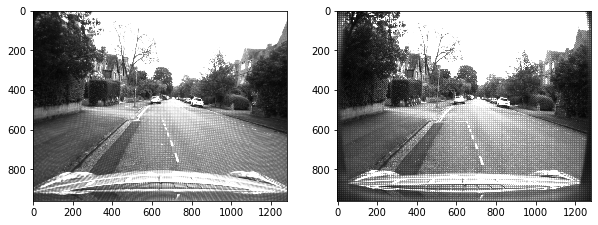

In [4]:
img1 = cv2.imread(BasePath+impaths[100])
img2 = cv2.imread(BasePath+impaths[101])

und1 = UndistortImage(img1,LUT)
und2 = UndistortImage(img2,LUT)
BasePath+impaths[0]
fs,plots = plt.subplots(1,2, figsize = (10,10))
plots[1].imshow(img2)
plots[0].imshow(und2)

# Obtaining keypoints

In [5]:
# def keypoints(img1, img2):   
MIN_MATCH_COUNT = 10

# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)


FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

flann = cv2.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(des1, des2, k=2)

# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

pts1 = np.array([kp1[m.queryIdx].pt for m in good]).reshape(-1, 2)
pts2 = np.array([kp2[m.trainIdx].pt for m in good]).reshape(-1, 2)
    
#     return pts1, pts2
# pts1, pts2 = keypoints(img1,img2)
print(pts1.shape, pts2.shape) ## (x,y)

(1833, 2) (1833, 2)


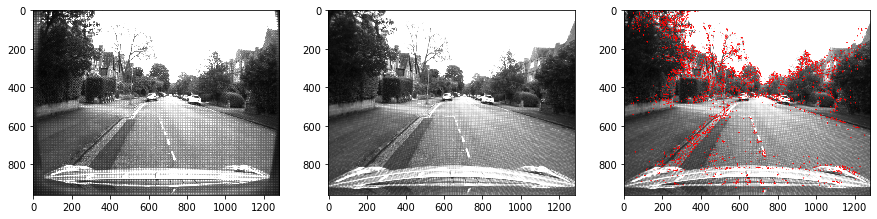

In [6]:
# printing Key points
destimg = np.copy(img1)
cv2.drawKeypoints(und1, kp1, destimg, color = (255, 0, 0))  
fs,plots = plt.subplots(1,3, figsize = (15,10))
plots[0].imshow(img2)
plots[1].imshow(und2)
plots[2].imshow(destimg)

####  What is the actual goal of Fundamental matrix?
1) Take two consecutive images  with their keypoints

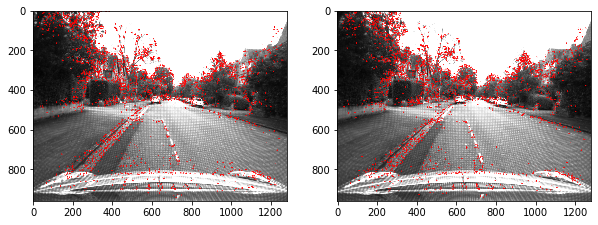

In [7]:
dimg1 = np.copy(img1)
dimg2 = np.copy(img2)
cv2.drawKeypoints(und1, kp1, dimg1, color = (255, 0, 0))  
cv2.drawKeypoints(und2, kp2, dimg2, color = (255, 0, 0))  
fs,plots = plt.subplots(1,2, figsize = (10,10))
plots[0].imshow(dimg1)
plots[1].imshow(dimg2)

2) The keypoint scatter plots:

- Notice that the scatter plots for both images are off by a small rotation + translation.

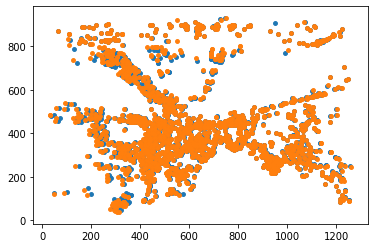

In [8]:
plt.scatter(pts1[:,0],pts1[:,1],s=15)
plt.scatter(pts2[:,0],pts2[:,1],s=15)

3) Normalise the keypoints to be within -1,1 and zero center. We shall look at the reasons for doing this below

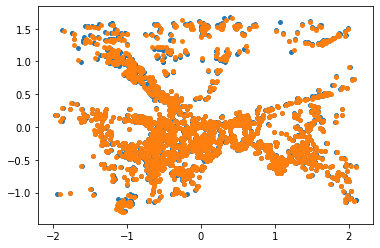

In [9]:
def normalise(points):
    mean1 = np.mean(points[:, 0])
    mean2 = np.mean(points[:, 1])

    d = np.mean(np.sqrt((points[:, 0] - mean1) ** 2 + (points[:, 1] - mean2) ** 2))

    P = np.array([[1 / d, 0, -mean1 / d], [0, 1 / d, -mean2 / d], [0, 0, 1]])
    points = np.insert(points, 2, 1, axis=1)

    P1 = np.dot(P, points.T)
    P1 = P1.T

    return P1, P

x1, P1 = normalise(pts1)
x2, P2 = normalise(pts2)

plt.scatter(x1[:,0],x1[:,1],s=15)
plt.scatter(x2[:,0],x2[:,1],s=15)

- The goal of fundamental matrix is to estimate the rotation and translation matrix aka the projective transformation between these two images

### But What is normalization ?

The basic eight-point algorithm can in principle be used also for estimating the fundamental matrix F . The defining constraint for F  is:

 (y′)T .F.y = 0 

where y , y ′ are the homogeneous representations of corresponding image coordinates (not necessary normalized). This means that it is possible to form a matrix Y by solving the equation

  (f)T. Y = 0 
    
- Y needs to have one zero and remaining non zeros.  In practice, however, some of the non-zero singular values can become small relative to the larger ones. This is an illcondition that affects the performance

- If [x,y,1]T  = [1000,2000,1]T , then we see that the first and second coordinate are much larger than the third coordinate. 
  This accounts to that ill-condition stated above. This can be addressed by normalizing the keypoints with a T matrix.

- The T matrix scales down the keypoints and adjusts the image centroid to be in the origin.


note: here T = Transpose


In [10]:
points = pts1
# obtain mean
mean1 = np.mean(points[:, 0])
mean2 = np.mean(points[:, 1])

d = np.mean(np.sqrt((points[:, 0] - mean1) ** 2 + (points[:, 1] - mean2) ** 2))

# construct normalisation matrix [[ax, 0, dx], [0, ay, dy], [0, 0, 1]]
Tn = np.array([[1 / d, 0, -mean1 / d], [0, 1 / d, -mean2 / d], [0, 0, 1]])

In [11]:
# insert the last column for [x,y,1]
points = np.insert( points, 2, 1, axis=1)

# dot product of normalisation matrix with the keypoint vector and transpose it
P1 = np.dot(Tn, points.T)
P1 = P1.T 


# Learning to estimate Fundamental matrix using 8 point algorithm

input  = pts1,pts2   --- the keypoints

output = The finalised Fundamental matrix



1 - Random sample 8 key points for the Fundamental matrix estimation using 8 point method

2 - Collect those sift key points and normalize them

3 -  Build the A matrix from the 8 keypoints

4 - Do singular value decomposition of A matrix to obtain V. The last row of V is fundamental matrix.

5 - Since the Fundamental matrix can be wrong due to noise as the SVD rank would not be 2 but a very low value at the last row,
    we singular value decompose the fundamental matrix again, obtain the S matrix, force the last row = 0  to obtain rank 2 and remultiply to obtain final
    fundamental matrix

6 - For all M F matrices found by sampling 8 random pairs, line fitting it done to estimaate the final F matrix by RANSAC algorithm.

In [12]:
indices = [i for i in range(pts1.shape[0])] # Create and indice list of all keypoints
indices_8 = sample(indices, 8) # sample 8 indices in random

In [13]:
i=0
x1_list = list()
x2_list = list()
# x1_list.insert(0, pts1[indices_8])
# x2_list.insert(0, pts2[indices_8])
x1_list= pts1[indices_8]
x2_list= pts2[indices_8]


# print(pts1[indices_8], '\n\n\n', pts2[indices_8])
print(x1_list, '\n\n\n', x2_list)

[[ 595.31030273  455.3861084 ]
 [ 424.33505249  247.23721313]
 [ 934.74279785  298.86013794]
 [ 288.86965942  741.91156006]
 [1213.796875    185.78225708]
 [1158.03088379  831.29882812]
 [1145.61071777  821.90258789]
 [ 296.44488525  707.13049316]] 


 [[ 593.6116333   455.41845703]
 [ 420.96520996  247.0585022 ]
 [ 934.41210938  297.59228516]
 [ 275.3800354   753.12927246]
 [1220.19946289  180.94934082]
 [1157.99365234  831.34576416]
 [1145.88427734  822.79711914]
 [ 283.41046143  716.61999512]]


In [14]:
# normalise the 8 points pairs
x, Tn1 = normalise(x1_list)
x1, Tn2 = normalise(x2_list)

In [15]:
n = x1.shape[0]
if x.shape[0] != n:
    raise ValueError("Number of points don't match.")

    
# Build  A-matrix for equations
A = np.zeros((n, 9)) # 8x9 matrix 
for i in range(n):
    
    A[i] = [ x[i, 0] * x1[i, 0], x[i, 0] * x1[i, 1], x[i, 0],
             x[i, 1] * x1[i, 0], x[i, 1] * x1[i, 1], x[i, 1], 
             x1[i, 0], x1[i, 1], 1 ]
    
print(A.shape)

(8, 9)


In [16]:
# compute linear least square solution

U, S, V = np.linalg.svd(A) # single value decomposition to get the S matrix
print('Decomposition of A matrix: \n')
print(U.shape,S.shape,V.shape)

F = V[:, 8].reshape(3, 3)  # take last row alone and  constrain F (Size is incompatible)
print(' The incorrect fundamental matrix: \n')
print(F.shape)

U, S, V = np.linalg.svd(F) # obtain the Singular value diagonal for the estimated fundamental matrix
print(' The Decomposition of F matrix: \n')
print(U.shape,S.shape,V.shape)
# force it to rank 2 by zeroing out last singular value
S[2] = 0


# find multiply ie find dot products back to obtain corrected fundamental matrix
F = np.dot(U, np.dot(np.diag(S), V))

# De-normalise the matrix by finding dot product with Tn matrix
F = np.dot(Tn1.T, np.dot(F, Tn2))
print(' Corrected Fundamental matrix : \n')
F / F[2, 2]    
print(F)

## make this a function getfundamentalmatrix()

Decomposition of A matrix: 

(8, 8) (8,) (9, 9)
 The incorrect fundamental matrix: 

(3, 3)
 The Decomposition of F matrix: 

(3, 3) (3,) (3, 3)
 Corrected Fundamental matrix : 

[[-3.85212761e-06  1.77445680e-07  2.79256988e-03]
 [ 1.45397201e-06 -3.21257372e-06  6.76025913e-04]
 [ 2.13279546e-03  1.58473342e-03 -2.47178825e+00]]


# Find The Best Fundamental matrix by line fitting with RANSAC

For 50 iterations:
 - select 8 indices randomly and obtain fundamental matrix
 - For every keypoint pair, 
 
      - find error for this given fundamental matrix
      - if error less than 0.999, mark the keypoint as an inlier, else its an outlier
      - repeat until all keypoints are completed
      
      
 - Check if the current F matrix had more inliers than previous F matrix. If yes, keep it as best known Fmatrix, else, ignore
 - Repeat for all 50 iterations of fundamental matrix estimation to find the best option
 

In [17]:
X1,X2 = pts1,pts2

l = X1.shape[0]
M=40 # 40 ransac iterations
indices = [i for i in range(pts1.shape[0])] # Create and indice list of all keypoints
index = 0

x1_list = list()
x2_list = list()
current_inlier_list = list()
prev_inlier_list = list()
best_inlier = list()
F_list = list()
F = np.zeros((3, 3))

In [18]:
def errorCond(x1,x2,F):
    x1 = x1.T
    err = np.matmul(x2,F)
    err = np.matmul(err,x1)
    err  =abs(np.squeeze(err))
    return err

x1 = np.insert(X1[1], 2, 1, axis=0)
x2 = np.insert(X2[1], 2, 1, axis=0)
print(x1,x2,'\n')
print(F,'\n\n')
error = errorCond(x1,x2,F)


[ 47.04402924 482.55065918   1.        ] [ 33.28835297 484.7331543    1.        ] 

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]] 




In [19]:
# for the given fundamental matrix, estimated by the randomly chosen 8 keypoint list pair, 
# find the error by line fitting and count the inliers
print('Running a 1 RANSAC iterations:\n')
for i in range(0,5):
    current_inlier_list.clear()
    print('Start iteration',i,': \n')
    indices_8 = sample(indices, 8) # sample 8 indices in random
    print('Indices at :',i,'\n',indices_8)
    
    x1_list.insert(i , X1[indices_8])
    x2_list.insert(i , X2[indices_8])
    print('inserted  keypoints: \n', x1_list,'and \n\n',x2_list,'\n')

    print('sampled  keypoints at ',i,': \n', x1_list[i],'and \n\n',x2_list[i],'\n')
    
    F_list.insert(i , getFmatrix(x1_list[i], x2_list[i]))
    
    print('Fmatrix for these keypoints :\n',F_list,'\n')
    print('Run RANSAC for this Fmatrix for 10 keypoints : \n') ## do it for all the keypoints in  actual practice
    for j in range(10): 
        x1 = np.insert(X1[j], 2, 1, axis=0)
        x2 = np.insert(X2[j], 2, 1, axis=0)
        print('1) choose two keypoints one by one : \n', x1,'\n',x2,'\n')
        x1 = x1.reshape(3, 1)
        x2 = x2.reshape(3, 1)

    #         F.x1
        d1 = np.dot(F_list[i], x1)
        d2 = np.dot(F_list[i].T, x1)
        print('2) dot product of Fmatrix and the chosen keypoints: \n', d1,'\n',d2,'\n')
        
    #         find error
#         error = np.linalg.norm(np.abs(np.dot(x2.T, np.dot(F_list[i], x1))) / np.sqrt(np.dot(d1.T, d1) + np.dot(d2.T, d2)))

        #         find error by satisfying epipolar constraint 
        error = errorCond(x1,x2,F)
        
        print('3) Calculate Error: ', error,'\n')
    #         find inliers depending on error on epipolar constraint
        if error < 0.01:
            current_inlier_list.append([x1.T, x2.T])
            print('New Inliers:  ',current_inlier_list,'\n')
        else:
            print('Error too much, Suboptimal Fmatrix')
        print('--------------------','End of iteration',j,'--------------------\n------------------------------------------------------------')

    if len(current_inlier_list) > len(prev_inlier_list):
        best_inlier = np.asarray(current_inlier_list)
        F = F_list[i]
        
    print('\n Best inliers of iteration ',i,':\n',best_inlier)
    
    prev_inlier_list = current_inlier_list

    #             if no. of inliers in this iteration more than previous , consider this inlier list


Running a 1 RANSAC iterations:

Start iteration 0 : 

Indices at : 0 
 [838, 626, 1471, 94, 1157, 702, 1045, 853]
inserted  keypoints: 
 [array([[543.3637085 , 496.53137207],
       [472.60830688, 299.52697754],
       [924.48962402, 287.34561157],
       [251.13806152, 394.92114258],
       [676.10943604, 385.93084717],
       [500.71011353, 484.0317688 ],
       [624.98388672, 348.54730225],
       [548.89312744, 221.73033142]])] and 

 [array([[541.12689209, 496.99838257],
       [470.03536987, 298.76013184],
       [924.0425415 , 285.8104248 ],
       [243.96107483, 395.15841675],
       [674.60540771, 385.49920654],
       [497.98977661, 484.45651245],
       [623.41717529, 348.24285889],
       [547.27459717, 219.57194519]])] 

sampled  keypoints at  0 : 
 [[543.3637085  496.53137207]
 [472.60830688 299.52697754]
 [924.48962402 287.34561157]
 [251.13806152 394.92114258]
 [676.10943604 385.93084717]
 [500.71011353 484.0317688 ]
 [624.98388672 348.54730225]
 [548.89312744 221.73033

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 3 is different from 1)

# Estimate Essential Matrix
- Get Camera matrix K
- Get Fundamental matrix F
- Singular value decompose F and force the  rank to be 2 and remultiply to form F
- Compute K.T (F) K to find E
-  Singular value decompose E and force the matrix S to be [1,1,0] diagonal. Remultiplu to form E

In [20]:
F  = FmatrixRansac(pts1,pts2)
E = getEssentialMatrix(K,F)

In [21]:
# Camerapose Estimation

'''The camera pose consists of 6 degrees-of-freedom (DOF) Rotation (Roll, Pitch, Yaw) and Translation (X, Y, Z) of the camera with respect to the world. 
    Since the E matrix is identified, the four camera pose configurations: (C1,R1),(C2,R2),(C3,R3) and (C4,R4) 
'''

def getCameraPose(E):
    ''' To estimate camera pose from Essential matrix. 
    We get 4 types of poses out of this. We need to find the best estimate of these poses anyhow
    '''
    W = np.array([[0,-1,0],[1,0,0],[0,0,-1]])
    U,S,V = np.linalg.svd(E)

    C1,R1 = U[:,2], U @ W @ V
    if int(np.linalg.det(R1))  == -1:
        C1,R1 = -C1,-R1

    C2,R2 = -U[:,2], U @ W @ V.T
    if int(np.linalg.det(R2))  == -1:
        C2,R2 = -C2,-R2

    C3,R3 = U[:,2], U @ W.T @ V.T
    if int(np.linalg.det(R1))  == -1:
        C3,R3 = -C3,-R3

    C4,R4 = -U[:,2], U @ W.T @ V.T
    if int(np.linalg.det(R1))  == -1:
        C4,R4 = -C4,-R4

    C1,C2,C3,C4 = C1.reshape(3,1),C2.reshape(3,1),C3.reshape(3,1),C4.reshape(3,1)

    k = 1
    P1 = np.concatenate((k*R1,C1),axis = 1)
    P2 = np.concatenate((k*R2,C2),axis = 1)
    P3 = np.concatenate((k*R3,C3),axis = 1)
    P4 = np.concatenate((k*R4,C4),axis = 1)

    return [P1,P2,P3,P4]

poses= getCameraPose(E)

In [22]:
print(poses[0],'\n\n',poses[1],'\n\n',poses[2],'\n\n',poses[3])

[[-0.62946822 -0.77694178  0.01145563 -0.03182168]
 [-0.72331454  0.59127888  0.35665862  0.09728603]
 [-0.28387645  0.21621924 -0.93416455 -0.99474761]] 

 [[ 0.62920328  0.71955095 -0.29385314  0.03182168]
 [ 0.77292199 -0.61906521  0.13910382 -0.09728603]
 [-0.08182197 -0.31465013 -0.94567461  0.99474761]] 

 [[ 0.6378947   0.73418088 -0.23252695  0.03182168]
 [ 0.74635037 -0.66379222 -0.04838413 -0.09728603]
 [ 0.18987228  0.1426826   0.97138571  0.99474761]] 

 [[ 0.6378947   0.73418088 -0.23252695 -0.03182168]
 [ 0.74635037 -0.66379222 -0.04838413  0.09728603]
 [ 0.18987228  0.1426826   0.97138571 -0.99474761]]


# Linear Triangulation: 

It is the idea of estimating 3D world point with a given 2D key point correspondence pair sets in a given pair of images. 
 - take pts1 and pts2, non homogenous point
 - K-1.pts makes them homogenous coordinates
 - skew the points to form a 3x3 mtrix
 - Take the poses[R T] and convert them to [R R.T]
 - take P0 and P1, get dot products with the homogenous points
 - Append pose0 and pose1 on below th other, row-wise to form A matrix
 - Decompose the A matrix with SVD and obtain U, S and V matrix
 - last row of V matrix is the 3D solution

Check:
 
 https://www.youtube.com/watch?v=j8IKgaLsHys 
 
 http://www.cs.cmu.edu/~16385/s17/Slides/11.4_Triangulation.pdf

In [26]:
H1 = np.array([[1,0,0,0],
               [0,1,0,0],
               [0,0,1,0],
               [0,0,0,1]])
H1_custom = H1

P0 = H1[:3]
P1 = poses[0]
P1

array([[-0.62946822, -0.77694178,  0.01145563, -0.03182168],
       [-0.72331454,  0.59127888,  0.35665862,  0.09728603],
       [-0.28387645,  0.21621924, -0.93416455, -0.99474761]])

In [29]:
pt1 = pts1[0]
pt2 = pts2[0]

def skew(v):
    a=v[0]
    b=v[1]
    c=v[2]
    return np.array([[0,-c,b],[c,0,-a],[-b,a,0]])

# linear_triangulation(K,P0,poses[j],pts1[i],pts2[i])
# do it for all keypoints
# for i in range(len(pts1)):
    
pt1 = np.insert(np.float32(pt1),2,1)
pt2 = np.insert(np.float32(pt2),2,1)
print('2D points: \n')
print(pt1,'\n',pt2,'\n\n')

## matmul inverse of intrinsic camera matrix nd 2d points to estimate 3D points better
homo_pt1 = np.matmul(np.linalg.inv(K),pt1.reshape((-1,1)))
homo_pt2 = np.matmul(np.linalg.inv(K),pt2.reshape((-1,1)))
print('Homogenous 2D points: \n')
print(homo_pt1,'\n\n',homo_pt2,'\n\n')

skew0 = skew(homo_pt1.reshape((-1,)))
skew1 = skew(homo_pt2.reshape((-1,)))
print('Skew ?? : \n')
print(skew1,'\n\n',skew0,'\n\n')

print('P0 and Poses before : \n')
print(P0,'\n\n',P1,'\n\n')

# [R -RT] where R is P[:,:3] - first 3x3 matrix and T is P[:,3] last column
P0 = np.concatenate((P0[:,:3], -np.matmul(P0[:,:3],P0[:,3].reshape(-1,1))),axis=1)
P1 = np.concatenate((P1[:,:3], -np.matmul(P1[:,:3],P1[:,3].reshape(-1,1))),axis=1) 

print('P0 and Poses after but whaat ?? : \n')
print(P0,'\n\n',P1,'\n\n')

# P0 = homogeneousMat(P0)
# P1 = homogeneousMat(P1)

pose1 = np.matmul(skew0,P0[:3,:])
pose2 = np.matmul(skew1,P1[:3,:])
print('pose1 and pose2 : \n')
print(pose1,'\n\n',pose2,'\n\n')


#Solve the equation Ax=0
A = np.concatenate((pose1,pose2),axis=0)
print('Amtreix: \n')
print(A)
u,s,vt = np.linalg.svd(A)
print('\n Vt \n:', vt)
X = vt[-1]
X = X/X[3]    

print('\n Triangulated soltion: 3D point',X)
    

2D points: 

[ 38.09768 481.84976   1.     ] 
 [ 34.418613 483.65982    1.      ] 


Homogenous 2D points: 

[[-0.62776965]
 [-0.00265148]
 [ 1.        ]] 

 [[-6.31582824e-01]
 [-7.75442550e-04]
 [ 1.00000000e+00]] 


Skew ?? : 

[[ 0.00000000e+00 -1.00000000e+00 -7.75442550e-04]
 [ 1.00000000e+00  0.00000000e+00  6.31582824e-01]
 [ 7.75442550e-04 -6.31582824e-01  0.00000000e+00]] 

 [[ 0.         -1.         -0.00265148]
 [ 1.          0.          0.62776965]
 [ 0.00265148 -0.62776965  0.        ]] 


P0 and Poses before : 

[[1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]] 

 [[-0.62946822 -0.77694178  0.01145563 -0.03182168]
 [-0.72331454  0.59127888  0.35665862  0.09728603]
 [-0.28387645  0.21621924 -0.93416455 -0.99474761]] 


P0 and Poses after but whaat ?? : 

[[1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]] 

 [[-0.62946822 -0.77694178  0.01145563  0.0669503 ]
 [-0.72331454  0.59127888  0.35665862  0.27424505]
 [-0.28387645  0.21621924 -0.93416455 -0.95932649]] 


pose1 and pose2 : 

[[ 0.         -1.      

In [32]:
# Linear Triangulation - Method2

array([[-0.62946822, -0.77694178,  0.01145563],
       [-0.72331454,  0.59127888,  0.35665862],
       [-0.28387645,  0.21621924, -0.93416455]])

In [ ]:
check = 0
Horigin = np.identity(4)

for index in range(0, len(poses)):
    RotationMatrix = poses[index][:,:3]
    Translation_final = poses[index][:,3]
    
    angles = obtainEulerAngles(RotationMatrix[index])

    if angles[0] < 50 and angles[0] > -50 and angles[2] < 50 and angles[2] > -50:

        count = 0
        newP = np.hstack((RotationMatrix[index], CameraCenter[index]))
        for i in range(0, len(features1)):
            temp1x = getTriangulationPoint(Horigin[0:3,:], newP, features1[i], features2[i])
            thirdrow = RotationMatrix[index][2,:].reshape((1,3))
            if np.squeeze(thirdrow @ (temp1x - CameraCenter[index])) > 0: 
                count = count + 1

        if count > check:
            check = count
            Translation_final = CameraCenter[index]
            Rotation_final = RotationMatrix[index]

if Translation_final[2] > 0:
    Translation_final = -Translation_final


In [ ]:
pts1, pts2 = keypoints(und1,und2)
# print(pts1.shape)
if pts1.shape[0] <8:
    continue

F_custom, x1_in, x2_in = compute_fundamental_ransac(pts1, pts2)
E_custom = findEssentialMatrix(K,pts1, pts2)
poses = extract_camera_pose(E_custom)

cumulative_points = dict()
for j in range(4):
   X = []
   for i in range(len(pts1)):
       pt = linear_triangulation(K,P0,poses[j],pts1[i],pts2[i])
       X.append(pt)
   # print("Pose" + str(j))
   cumulative_points.update({j:X})
correctPose,no_inlier,poseid = find_correct_pose(P0, poses, cumulative_points)
R_custom = correctPose[:,:3].reshape(3,3)
C_custom = correctPose[:,3].reshape(3,1)

if np.linalg.det(R_custom)<0:
    R_custom = -R_custom

H2_custom = np.hstack((R_custom,np.matmul(-R_custom,C_custom)))
H2_custom = np.vstack((H2_custom,[0,0,0,1]))

H1_custom = np.matmul(H1_custom,H2_custom)
pos_custom = np.matmul(-H1_custom[:3,:3].T,H1_custom[:3,3].reshape(-1,1))

print("Frame number: ",iter)

x_camera = H1_custom[0,3]

z_camera = H1_custom[2,3]

plt.plot(x_camera,-z_camera,'.r')